<a href="https://colab.research.google.com/github/adrianstop/EmTrack/blob/main/emTrack_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Classification

## Setup Python Environment 

The next cell sets up the dependencies required for the notebook.

In [ ]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow
!pip install tinymlgen

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tinymlgen: filename=tinymlgen-0.2-py3-none-any.whl size=2242 sha256=00aba6db933e0f143a817ebeb72e4869336b7e69b28c537303719c881729a008
  Stored in directory: /root/.cache/pip/wheels/7a/a1/f5/2884c682bcacd0a96875431737d5c792e8dd0a1e4e163512be
  Created wheel for hexdump: filename=hexdump-3.3-py3-none-any.whl size=8913 sha256=11729d7402554be22d2b518a866ef7a2c2d2cd1b9014d6410c1b35bf4a85a7f7
  Stored in directory: /root/.cache/pip/wheels/7f/b7/72/1cc327e831ffef71bca1b0ca5e40b68471875f740ec9270c0f
Successfully built tinymlgen hexdump


## Get Data


In [ ]:
# 30 sample of each dataset
#!wget https://github.com/adrianstop/arduino-magic-wand/raw/main/training_data/training_data.tar
#!tar xf training_data.tar
#!rm -rf training_data.tar

# 50 sample of each dataset
!wget https://github.com/adrianstop/arduino-magic-wand/raw/main/training_data/training_data_large.tar
!tar xf training_data_large.tar
!rm -rf training_data_large.tar

#!tar xf CLASS.tar
#!rm -rf CLASS.tar

#!tar xf OLGA.tar
#!rm -rf OLGA.tar

--2023-01-18 20:17:13--  https://github.com/adrianstop/arduino-magic-wand/raw/main/training_data/training_data_large.tar
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/adrianstop/arduino-magic-wand/main/training_data/training_data_large.tar [following]
--2023-01-18 20:17:14--  https://raw.githubusercontent.com/adrianstop/arduino-magic-wand/main/training_data/training_data_large.tar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1929216 (1.8M) [application/octet-stream]
Saving to: ‘training_data_large.tar’

training_data_large 100%[===================>]   1.84M  --.-KB/s    in 0.04s   

2023-01

## Plot Data

We'll graph the input files on two separate graphs, acceleration and gyroscope, as each data set has different units and scale.

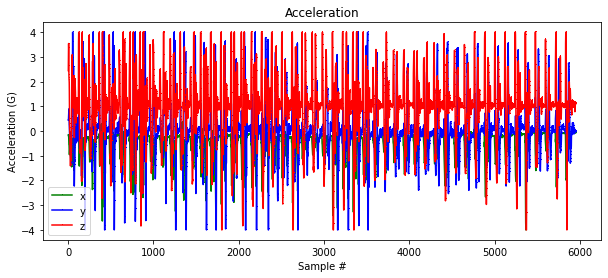

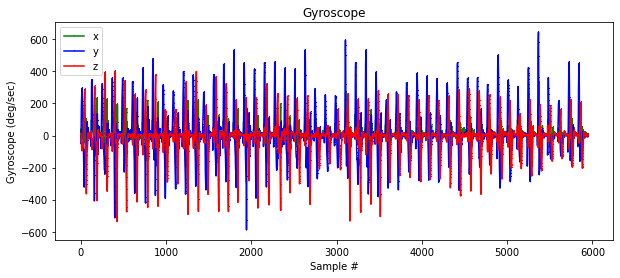

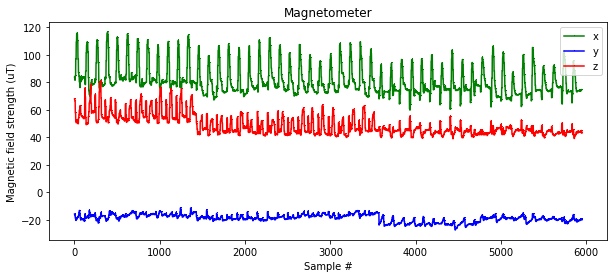

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# filename = "alohomora.csv"
# filename = "arresto_momentum.csv"
# filename = "avadakedavra.csv"
filename = "locomotor.csv"
#filename = "revelio.csv"

df = pd.read_csv(filename)

index = range(1, len(df['aX']) + 1)

plt.rcParams["figure.figsize"] = (10,4)

plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()

plt.plot(index, df['mX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['mY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['mZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Magnetometer")
plt.xlabel("Sample #")
plt.ylabel("Magnetic field strength (uT)")
plt.legend()
plt.show()


## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the fully connected neural network.

Update the `FORMULAS` list with the gesture data you've collected in `.csv` format.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of formulas that data is available for
FORMULAS = [
    "alohomora",
    "momentum",
    "avadakedavra",
    "locomotor",
    "revelio"  
]

SAMPLES_PER_FORMULA = 119
AVERAGE_NUM_SAMPLES = 1
NUM_FORMULAS = len(FORMULAS)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_FORMULAS = np.eye(NUM_FORMULAS)

inputs = []
outputs = []

# read each csv file and push an input and output
for formula_index in range(NUM_FORMULAS):
  formula = FORMULAS[formula_index]
  print(f"Processing index {formula_index} for formula '{formula}'.")
  
  output = ONE_HOT_ENCODED_FORMULAS[formula_index]
  
  df = pd.read_csv(formula + ".csv")
  
  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_FORMULA)
  
  print(f"\tThere are {num_recordings} recordings of the {formula} formula.")
  
  for i in range(num_recordings):
    tensor = []
    datapoint = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    for j in range(SAMPLES_PER_FORMULA):
      index = i * SAMPLES_PER_FORMULA + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      # - magnetometer is between: -400 to +400
      datapoint = [
          ((df['aX'][index] + 4) / 8)/AVERAGE_NUM_SAMPLES + datapoint[0],
          ((df['aY'][index] + 4) / 8)/AVERAGE_NUM_SAMPLES + datapoint[1],
          ((df['aZ'][index] + 4) / 8)/AVERAGE_NUM_SAMPLES + datapoint[2],
          ((df['gX'][index] + 2000) / 4000)/AVERAGE_NUM_SAMPLES + datapoint[3],
          ((df['gY'][index] + 2000) / 4000)/AVERAGE_NUM_SAMPLES + datapoint[4],
          ((df['gZ'][index] + 2000) / 4000)/AVERAGE_NUM_SAMPLES + datapoint[5],
          ((df['mX'][index] + 400) / 800)/AVERAGE_NUM_SAMPLES + datapoint[6],
          ((df['mY'][index] + 400) / 800)/AVERAGE_NUM_SAMPLES + datapoint[7],
          ((df['mZ'][index] + 400) / 800)/AVERAGE_NUM_SAMPLES + datapoint[8]
      ]
      if(j%AVERAGE_NUM_SAMPLES == 0):
        tensor += datapoint
        datapoint = [0, 0, 0, 0, 0, 0, 0, 0, 0]
      
    #tensor_t = list(map(list, zip(*tensor))) # transpose data
    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs, dtype='float32')
outputs = np.array(outputs, dtype='float32')

print("Data set parsing and preparation complete.")
#print(inputs)

TensorFlow version = 2.9.2

Processing index 0 for formula 'alohomora'.
	There are 60 recordings of the alohomora formula.
Processing index 1 for formula 'momentum'.
	There are 60 recordings of the momentum formula.
Processing index 2 for formula 'avadakedavra'.
	There are 59 recordings of the avadakedavra formula.
Processing index 3 for formula 'locomotor'.
	There are 60 recordings of the locomotor formula.
Processing index 4 for formula 'revelio'.
	There are 60 recordings of the revelio formula.
Data set parsing and preparation complete.


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

outputs_n = []
for i in range(outputs.shape[0]):
  for j in range(outputs.shape[1]):    
    if(outputs[i][j] == 1):
      outputs_n.append(j)
print(outputs_n)

K = 200
selector = SelectKBest(f_classif, k=K)
selected_features = selector.fit_transform(inputs, outputs_n)
f_score_indexes = (-selector.scores_).argsort()[:K]
# print(f_score_indexes)
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(selector.scores_)
plt.title('F-score')
plt.xlabel('feature')
plt.ylabel('Importance')
plt.legend()
plt.show()


[0, 4, 1, 3, 3, 2, 1, 2, 0, 3, 0, 4, 1, 0, 1, 1, 0, 3, 4, 1, 1, 0, 4, 1, 1, 0, 2, 1, 1, 0, 3, 1, 2, 1, 0, 3, 3, 3, 0, 1, 1, 0, 4, 2, 0, 2, 0, 0, 0, 3, 2, 0, 2, 0, 4, 4, 0, 1, 1, 0, 2, 0, 4, 1, 1, 0, 0, 4, 2, 0, 0, 4, 1, 3, 0]


ValueError: ignored

## Randomize and split the input and output pairs for training

Randomly split input and output pairs into sets of data: 60% for training, 20% for validation, and 20% for testing.

  - the training set is used to train the model
  - the validation set is used to measure how well the model is performing during training
  - the testing set is used to test the model after training

In [ ]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
inputs = inputs.reshape(inputs.shape[0], 1, inputs.shape[1])
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.7 * num_inputs)
TEST_SPLIT = int(0.1 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])
print(inputs_train.shape)
print("Data set randomization and splitting complete.")

(209, 1, 1071)
Data set randomization and splitting complete.


## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [ ]:
# build the model

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(inputs_train.shape[1], inputs_train.shape[2])),
    tf.keras.layers.LSTM(30, unroll=False, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(NUM_FORMULAS, activation='softmax')
])

In [ ]:
# Training parameters
num_epochs = 500
es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience=100, restore_best_weights=True)
lr_values = [1e-3, 1e-4]
lr_boundaries = [num_inputs/2]
lr_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(lr_boundaries, lr_values)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_fn)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['mae', 'accuracy'])

# Train the model 
history = model.fit(inputs_train, outputs_train, epochs=num_epochs, batch_size=1, validation_data=(inputs_validate, outputs_validate), callbacks=[es])

Epoch 1/500
175/175 [==============================] - 3s 7ms/step - loss: 1.6998 - mae: 0.3188 - accuracy: 0.2343 - val_loss: 1.6484 - val_mae: 0.3223 - val_accuracy: 0.1200
Epoch 2/500
175/175 [==============================] - 1s 4ms/step - loss: 1.6963 - mae: 0.3194 - accuracy: 0.1943 - val_loss: 1.6507 - val_mae: 0.3222 - val_accuracy: 0.1200
Epoch 3/500
175/175 [==============================] - 1s 4ms/step - loss: 1.6744 - mae: 0.3180 - accuracy: 0.2400 - val_loss: 1.6349 - val_mae: 0.3207 - val_accuracy: 0.1200
Epoch 4/500
175/175 [==============================] - 1s 3ms/step - loss: 1.6286 - mae: 0.3173 - accuracy: 0.2343 - val_loss: 1.5791 - val_mae: 0.3171 - val_accuracy: 0.3600
Epoch 5/500
175/175 [==============================] - 1s 4ms/step - loss: 1.5927 - mae: 0.3169 - accuracy: 0.2457 - val_loss: 1.5567 - val_mae: 0.3154 - val_accuracy: 0.3200
Epoch 6/500
175/175 [==============================] - 1s 4ms/step - loss: 1.5562 - mae: 0.3138 - accuracy: 0.3371 - val_loss

## Measure FLOPs

In [ ]:
pip install keras-flops

In [ ]:
# get_flops not supported for LSTM network

#from keras_flops import get_flops

#flops = get_flops(model, batch_size=1)
#print(f"FLOPS: {flops / 10 ** 3:.03} K")

## Verify 

Graph the models performance vs validation.


In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 30)             132240    
                                                                 
 dropout (Dropout)           (None, 1, 30)             0         
                                                                 
 flatten (Flatten)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 5)                 155       
                                                                 
Total params: 132,395
Trainable params: 132,395
Non-trainable params: 0
_________________________________________________________________
None


### Graph the loss

Graph the loss to see when the model stops improving.

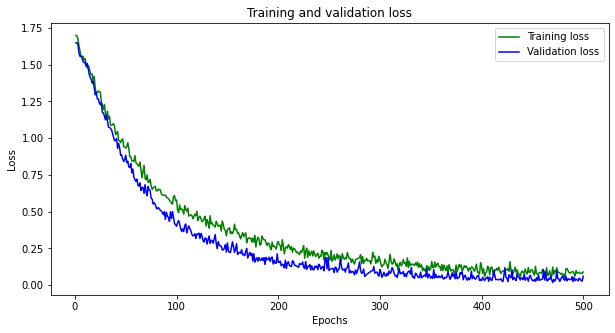

[10.0, 5.0]


In [ ]:
plt.rcParams["figure.figsize"] = (10,5)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

### Graph the mean absolute error

[Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) is another metric to judge the performance of the model.



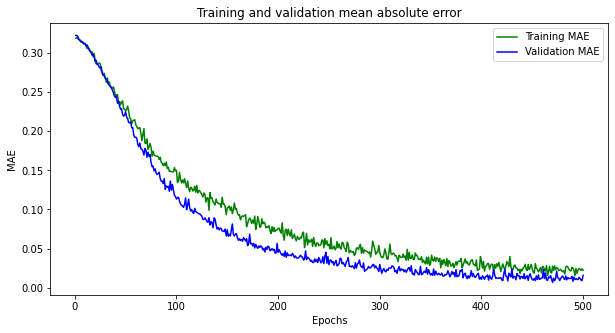

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)

# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[:], mae[:], 'g-', label='Training MAE')
plt.plot(epochs[:], val_mae[:], 'b-', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


### Run with Test Data
Put our test data into the model and plot the predictions


In [ ]:
# use the model to predict the test inputs
predictions = model.predict(inputs)
predictions_round = np.round(predictions, decimals=0)

loss, mae, acc = model.evaluate(inputs, outputs)
print("Loss CLASS dataset: {:.4f}".format(loss))
print("MAE CLASS dataset: {:.4f}".format(mae))
print("Accuracy CLASS dataset: {:.4f}".format(acc))

# print the predictions and the expected ouputs
#print("predictions =\n", predictions_round)
#print("actual =\n", outputs)

mistake_counter = 0
for i in range(len(predictions_round)):
  for j in range(len(predictions_round[1])):
    if predictions_round[i][j] != outputs[i][j]:
      mistake_counter += 1
      break

print("Correct predictions: {0} out of {1} = {2} %".format((len(outputs) - mistake_counter), len(outputs), 100*((len(outputs) - mistake_counter)/len(outputs))))

inputs_2d = inputs.reshape(inputs.shape[0], inputs.shape[2])


10/10 [==============================] - 0s 5ms/step - loss: 2.3383 - mae: 0.2273 - accuracy: 0.4415
Loss CLASS dataset: 2.3383
MAE CLASS dataset: 0.2273
Accuracy CLASS dataset: 0.4415
Correct predictions: 124 out of 299 = 41.47157190635451 %


[Text(69.0, 0.5, 'Actual formula'),
 Text(0.5, 42.0, 'Predicted formula'),
 Text(0.5, 1.0, 'Confusion matrix')]

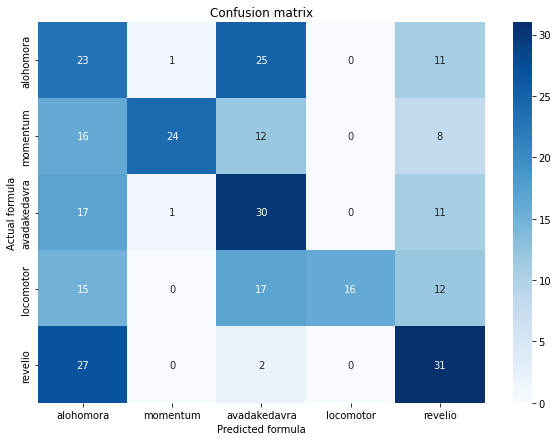

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

outputs_n = []
predictions_n = np.zeros(outputs.shape[0])
for i in range(outputs.shape[0]):
  for j in range(outputs.shape[1]):    
    if(outputs[i][j] == 1):
      outputs_n.append(j)
    if(predictions_round[i][j] > predictions_n[i]):
      predictions_n[i] = j

cfm = confusion_matrix(outputs_n, predictions_n)

df_cm = pd.DataFrame(cfm, index = FORMULAS,
                  columns = FORMULAS)
plt.figure(figsize = (10,7))
hm = sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
hm.set(xlabel='Predicted formula', ylabel='Actual formula', title='Confusion matrix')

# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [ ]:
run_model = tf.function(lambda x: model(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = inputs_train.shape[1]
INPUT_SIZE = inputs_train.shape[2]
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model.inputs[0].dtype))

# model directory.
MODEL_DIR = "keras_wand_lstm"
model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

# Save the model to disk
open("wand_model.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("wand_model.tflite")
print("Model is %d bytes" % basic_model_size)


# Encode the Model in an Arduino Header File 

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [ ]:
!echo "const unsigned char model[] = {" > model.h
!cat wand_model.tflite | xxd -i      >> model.h
!echo "};"                              >> model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Now it's time to switch back to the tutorial instructions and run our new model on the Arduino Nano 33 BLE Sense to classify the accelerometer and gyroscope data.

# Links

*   https://github.com/arduino/ArduinoTensorFlowLiteTutorials/
